In [1]:
#This is the notebook to set and train the clusterer
#Save in:
PATH_OUT = '/Users/augustecousin/Documents/bel_gm_tool/gm_tool/assets/'

In [2]:
import sys
sys.path.insert(0,"/Users/augustecousin/Documents/bel_gm_tool/gm_tool/")


In [3]:
sys.path


['/Users/augustecousin/Documents/bel_gm_tool/gm_tool/',
 '/Users/augustecousin/Documents/bel_gm_tool/gm_tool/model',
 '/Users/augustecousin/Library/CloudStorage/OneDrive-SharedLibraries-Pivot&Co/Bel 2022 - 1. Growth Modelling/2. Design (Tool)/_Auguste',
 '/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/augustecousin/Documents/envs/env/lib/python3.9/site-packages']

In [4]:
from datamanager.DM_Belgique import DM_Belgique

In [5]:
import pandas as pd
import numpy as np
import time
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import pickle

In [8]:
data_manager = DM_Belgique()
path = '../../../../Pivot & Co/Bel 2022 - 1. Growth Modelling/2. Design (Tool)/_Raoul/220207_Belgium_Dataset.csv'
data_manager.open_excel(path)
data_manager.df.rename(columns={'ACV': 'Distribution'}, inplace=True)

In [10]:
data_manager.df

,Date,Period,Week of year,Is month end,Is month start,Category,Sub Category,Brand,Distribution,Price per volume,Price without promo,Sales in volume,Number of Categories,Number of Sub Categories
0,2018-04-29,1,17,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,15.0,445.004850,460.132782,1.3403,1,1
1,2018-05-27,2,21,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,4.0,434.458058,435.385785,0.5305,1,1
2,2018-06-24,3,25,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,2.0,386.466165,387.121212,0.0133,1,1
3,2018-07-22,4,29,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,0.0,375.000000,375.000000,0.0008,1,1
4,2018-08-19,5,33,0,0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASARELLI,0.0,333.333333,333.333333,0.0003,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17155,2021-01-03,36,53,0,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1
17156,2021-01-31,37,4,1,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1
17157,2021-02-28,38,8,1,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1
17158,2021-03-28,39,12,0,0,TARTINES A POSER,ZZ AUTRES,SAINT ALBRAY,0.0,0.000000,0.000000,0.0000,2,1


In [13]:
df_kproto = data_manager.df[["Category", "Sub Category", "Brand", "Distribution", "Price per volume",
                       "Number of Categories", "Number of Sub Categories", "Sales in volume"]]

In [15]:
"""remove brand histories with more than 3 0.0 in their ACV"""
l_to_remove=[]
count=0
for filters, group in df_kproto.groupby(['Category', 'Sub Category', 'Brand']):
    if np.count_nonzero(group['Distribution']) < (40-3):
        l_to_remove.append(group.index.values)
l_to_remove = np.array(l_to_remove).flatten()

df_kproto=df_kproto[~df_kproto.index.isin(l_to_remove)].reset_index(drop=True)

In [17]:
df_kproto['Distribution'] = df_kproto['Distribution'].apply(np.log1p)
df_kproto['Price per volume'] = df_kproto['Price per volume'].apply(np.log1p)

In [21]:
df_sub = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_31098/4005983464.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Number of Categories', 'Number of Sub Categories'].max()


In [22]:
"""compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
Distribution = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
    {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
)

Price = df_kproto.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
    {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
)

In [23]:
"""merge high level metrics into df_sub"""
df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])

In [24]:
df_sub

,Category,Sub Category,Brand,Number of Categories,Number of Sub Categories,min Distribution,max Distribution,mean Distribution,std Distribution,min Price,max Price,mean Price,std Price
0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASTELLI,3,2,0.693147,0.693147,0.693147,0.000000,6.962972,7.522687,7.220754,0.081275
1,AIDE CULINAIRE,MASCARPONE/RICOTTA,GALBANI,9,2,4.356709,4.499810,4.388266,0.024585,6.490013,6.691947,6.609189,0.051866
2,AIDE CULINAIRE,MOZZARELLA,CASTELLI,3,2,0.693147,0.693147,0.693147,0.000000,7.518882,7.847390,7.658207,0.078099
3,AIDE CULINAIRE,MOZZARELLA,DILEA,7,2,2.708050,3.663562,3.264676,0.367531,6.332282,6.487478,6.409857,0.044493
4,AIDE CULINAIRE,MOZZARELLA,GALBANI,9,2,4.369448,4.442651,4.397714,0.015959,6.704671,6.845769,6.777376,0.044794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,TARTINES A POSER,PP,VACHE QUI RIT,2,2,2.995732,3.218876,3.075345,0.063060,7.307402,7.488436,7.420320,0.041922
230,TARTINES A POSER,PP,VLASKAAS,2,1,1.609438,2.944439,2.551167,0.306262,7.321925,7.693178,7.460314,0.109101
231,TARTINES A POSER,PP,WEIGHT WATCHERS,3,1,3.850148,4.356709,4.236240,0.118954,7.502348,7.610461,7.553426,0.029203
232,TARTINES A POSER,ZZ AUTRES,COEUR DE LION,2,1,2.944439,3.737670,3.070702,0.149337,7.606942,7.808834,7.686257,0.046255


In [27]:
"""elbow method for number of clusters"""
cost = []
K = range(2, 16)
for num_clusters in list(K):
    start = time.time()
    model = KPrototypes(n_clusters=num_clusters, init="Cao", n_init=1, max_iter=50, random_state=0)
    model.fit_predict(df_sub, 
                      categorical=[df_sub.columns.get_loc(column) for column in ["Category", "Sub Category", "Brand"]])
    end = time.time()
    cost.append(model.cost_)
    print("Number of clusters:", num_clusters, " | Runtime (s):", round(end-start, 2), " | Cost:", round(model.cost_, 2))

Number of clusters: 2  | Runtime (s): 0.07  | Cost: 2609.62
Number of clusters: 3  | Runtime (s): 0.06  | Cost: 2012.51
Number of clusters: 4  | Runtime (s): 0.06  | Cost: 1776.9
Number of clusters: 5  | Runtime (s): 0.13  | Cost: 1662.55
Number of clusters: 6  | Runtime (s): 0.11  | Cost: 1551.23
Number of clusters: 7  | Runtime (s): 0.19  | Cost: 1484.8
Number of clusters: 8  | Runtime (s): 0.12  | Cost: 1438.46
Number of clusters: 9  | Runtime (s): 0.13  | Cost: 1362.56
Number of clusters: 10  | Runtime (s): 0.14  | Cost: 1324.88
Number of clusters: 11  | Runtime (s): 0.13  | Cost: 1292.65
Number of clusters: 12  | Runtime (s): 0.13  | Cost: 1249.56
Number of clusters: 13  | Runtime (s): 0.15  | Cost: 1247.67
Number of clusters: 14  | Runtime (s): 0.2  | Cost: 1207.61
Number of clusters: 15  | Runtime (s): 0.15  | Cost: 1206.95


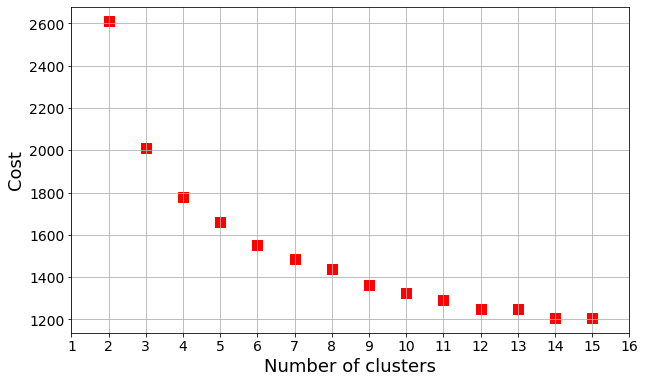

In [28]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams.update({'font.size': 14})
plt.scatter(x=K, y=cost,
            marker="s", s=100, color="red")
plt.xlabel("Number of clusters", fontsize=18)
plt.ylabel("Cost", fontsize=18)
plt.xticks(range(1, 17, 1))
plt.grid()
plt.show()

In [29]:
"""create and train clustering algorithm with n clusters"""
n_clusters=5
model = KPrototypes(n_clusters=n_clusters, init="Cao", max_iter=50, random_state=0)
model.fit(df_sub.values, 
          categorical=[df_sub.columns.get_loc(column) for column in ["Category", "Sub Category", "Brand"]])

KPrototypes(gamma=1.4493356689942827, max_iter=50, n_clusters=5, random_state=0)

In [52]:
"""save model as clusterer_Belgium.sav"""
#pickle.dump(model, open(PATH_OUT + 'clusterer_Belgium.sav', 'wb'))

'save model as clusterer_Belgium.sav'

In [30]:
"""store clusters and profiles"""
df_sub["Cluster"] = model.labels_

dict_clusters_sales = dict()
dict_all_sales = {x:{} for x in range(n_clusters)}
#TODO: with groupby is better
for index, row in df_sub.iterrows():
    sales = df_kproto[df_kproto['Category']==row['Category']]\
                     [df_kproto['Sub Category']==row['Sub Category']]\
                     [df_kproto['Brand']==row['Brand']]["Sales in volume"].values
    
    
    dict_all_sales[row["Cluster"]][row["Brand"]+row["Category"]+row["Sub Category"]] = sales
    
    
    if row["Cluster"] not in dict_clusters_sales:
        dict_clusters_sales[row["Cluster"]] = sales
    else:
        dict_clusters_sales[row["Cluster"]] += sales
    
for i in range(0, n_clusters):
    dict_clusters_sales[i] = dict_clusters_sales[i] / df_sub["Cluster"].value_counts().sort_index().values[i]

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_31098/839584110.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales = df_kproto[df_kproto['Category']==row['Category']]\


In [32]:
"""save clusters and profiles"""
profiles = pd.DataFrame(dict_clusters_sales)
#profiles.to_csv(PATH_OUT+'profiles_Belgium.csv', index=False)

clusters = df_sub[['Category', 'Sub Category', 'Brand', 'Cluster']]
#clusters.to_csv(PATH_OUT+'clusters_Belgium.csv', index=False)

In [33]:
df_sub

,Category,Sub Category,Brand,Number of Categories,Number of Sub Categories,min Distribution,max Distribution,mean Distribution,std Distribution,min Price,max Price,mean Price,std Price,Cluster
0,AIDE CULINAIRE,MASCARPONE/RICOTTA,CASTELLI,3,2,0.693147,0.693147,0.693147,0.000000,6.962972,7.522687,7.220754,0.081275,0
1,AIDE CULINAIRE,MASCARPONE/RICOTTA,GALBANI,9,2,4.356709,4.499810,4.388266,0.024585,6.490013,6.691947,6.609189,0.051866,1
2,AIDE CULINAIRE,MOZZARELLA,CASTELLI,3,2,0.693147,0.693147,0.693147,0.000000,7.518882,7.847390,7.658207,0.078099,0
3,AIDE CULINAIRE,MOZZARELLA,DILEA,7,2,2.708050,3.663562,3.264676,0.367531,6.332282,6.487478,6.409857,0.044493,1
4,AIDE CULINAIRE,MOZZARELLA,GALBANI,9,2,4.369448,4.442651,4.397714,0.015959,6.704671,6.845769,6.777376,0.044794,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,TARTINES A POSER,PP,VACHE QUI RIT,2,2,2.995732,3.218876,3.075345,0.063060,7.307402,7.488436,7.420320,0.041922,4
230,TARTINES A POSER,PP,VLASKAAS,2,1,1.609438,2.944439,2.551167,0.306262,7.321925,7.693178,7.460314,0.109101,4
231,TARTINES A POSER,PP,WEIGHT WATCHERS,3,1,3.850148,4.356709,4.236240,0.118954,7.502348,7.610461,7.553426,0.029203,3
232,TARTINES A POSER,ZZ AUTRES,COEUR DE LION,2,1,2.944439,3.737670,3.070702,0.149337,7.606942,7.808834,7.686257,0.046255,4
